# Data Mining - Assignment 1: Sentiment Analysis on Tweets<br>

by Athanasia Tournaki(1115201600172) & Dimitris Milonopoulos(1115201600112)

In this assignment, we were tasked to analyse the contents of tweets provided to us by the instructors, answer some statistical questions about them, as well as employ various methods in order to characterize the overall sentiment of a specific tweet as 'positive', 'negative' or 'neutral'.

The three methods used in order to achieve that were the Bag Of Words method, the TF-IDF method and Word Embeddings.

Two classifiers were used to draw conclusions for the data given, namely the Support-Vector Machine and the K-Nearest Neighbours Algorithm.

The rate at which every classifier-method combination succeeded in predicting the right sentiment was then computed, using the f1_score function.

## Step 1: Data Import

In this step, the panda library is used to read the .tsv files and save the contents in the 'train_data' and 'test _data' DataFrame variables.

In [1]:
import pandas as pd

In [2]:
## train_data ##

train_data = pd.read_csv('../twitter_data/train2017.tsv', sep='\t', encoding='utf-8', names=['id1', 'id2', 'emotion', 'tweet'])

#print(train_data)

In [3]:
## test_data ##

test_data = pd.read_csv('../twitter_data/test2017.tsv', sep='\t', encoding='utf-8', names=['id1', 'id2', 'emotion', 'tweet'])
#print(test_data)

## Step 2: Pre-processing, Data 'Cleaning'

In this step, unnecessary information is subtracted from the tweets and their format becomes easier to process.

In [4]:
### Some useful functions ###

import string
import re

def find_all(a_str, sub):
    # counts the number of occurencies of a substring in a string

    start = 0
    found = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1:
            return found
        found += 1
        start += len(sub)


def emoji_list(input_str):
    # returns a list of all the emojis found in the input string

    myset = {';-)', ':-O', ':^*', ':D', ':]', '>:[', ':-.', ':/', ':[', ':$', ':c)', '>:\\', '>.<', '=L', ':-Þ', 'x-D', '*\\0/*', 'o/\\o', 'X-D', ';-]', ':b', ':-||', ':L', ':-P', ':p', ';D', ':X', '>:(', 'o-o', '0:3', ':{', '\\o/', '=-3', ':っC', '=)', 'D8', ":'-(", 'D:<', ';(', ':^)', ':\\', ':-þ', ':-<', '=D', '%)', '^<_<', ":'-)", ':c', '0:-)', '#-)', '0:)', '>:-)', '8-D', 'X-P', 'O:-)', 'B^D', ':þ', 'O_O', ':P', ':o)', '^5', '*', '=/', "D-':", 'DX', '|-O', 'ಠ_ಠ', ';^)', ':-X', ':-p', ':&', 'XD', ':-#', '>:/', '8-0', ':)', '8D', ':3', ':っ)', 'D;', '=3', ';)', '</3', ':-b', ':#', '=\\', ':###..', ':Þ', '>:P', ':-[', 'xD', '>:O', 'D:', '>_>^', '=p', '0:-3', ':-J', ':-(', ':@', ':-c', '3:-)', ':-/', ':-|', 'O-O', 'XP', ':-o', ':o', ':-###..', ':*', 'xp', ':S', 'v.v', ':-))', '=]', ';]', '<3', ':-)', '>:)', ':-,', '%-)', '8)', 'O_o', '=-D', ':(', 'D=', 'x-p', ':|', ':O', ":')", '}:)', '0;^)', '>;)', ':}', '*-)', 'o_o', 'o_O', 'd:', '}:-)', ':-D', ':<', ":'(", '3:)', '|;-)', ':>', ':-&'}
    emoji_list = []
    for item in myset:
        if input_str.find(item) != -1:
            result = find_all(input_str, item)
            if(result > 0):
                for i in range(result):
                    emoji_list.append(item)

    return emoji_list

def clean_http(string): 
    # replaces all 'http' links in the given string with the '<url>' notation

    list_str = []
    words = string.split(" ")
    for word in words:
        index = word.find('http')
        if (index == 0):
            list_str.append('<url>')
        else:
            list_str.append(word)

    newstring = str(" ".join(list_str))
    return newstring

#### The following 'clean_input' function constitutes the main part of the 'cleaning' process. Its role consists of the following:

    -> Replacing all links with a '<url>' notation, which is useful later, when the tweets are interpreted by the provided lexica.
    
    -> Adding all emojis found throughout the tweet into a list, in order to preserve them during the cleaning process. This list is later appended to the end of the recently cleaned tweet.

    -> Removing unnecessary characters, such as numbers and sumbols with the exception of: the letters 'a' through 'z' and the sumbols '#', '@', '<' and '>'.

    -> Removing one-letter words and unecessary whitespaces.

In [5]:
def clean_input(string):

    newstring = clean_http(string)
    emojis = emoji_list(newstring)
    newstring = newstring.lower()
    # remove all characters except for letters 'a'-'z', '#', '@', '<', and '>')
    newstring = re.sub(r'[^a-z#@<>]', ' ', newstring)
    if emojis:
        emoji_str = " "
        for i, item in enumerate(emojis):
            if i == len(emojis)-1:
                emoji_str += item
                continue
            emoji_str += item + " "
        newstring += emoji_str
    #remove all one-letter words
    newstring = re.sub(r'\s+[a-zA-Z]\s+', ' ', newstring)
    newstring = re.sub(r'\^[a-zA-Z]\s+', ' ', newstring) 
    # remove unecessary whitespaces
    newstring = re.sub(r'\s+', ' ', newstring)
    return newstring

### 'Cleaning' the datasets

In [6]:
## train_data ##

train_data['tweet'] = train_data.tweet.apply(clean_input)

#print(train_data)

In [7]:
## test_data ##

test_data['tweet'] = test_data.tweet.apply(clean_input)

## Step 3: Tokenization,  Stop-Words Removal, Stemming

In this step, the NLTK library is used in order to lemmatize and remove some known Stop-Words from the tweets. We have taken the liberty of enriching the list of Stop-Words with some words deemed redundant in the context of this exercise, in order to improve the statistics later on. At the end of this step, the tweets are tokenized and converted into lists of words.

In [8]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def lem_tokens(token_list,wnl):

    return [wnl.lemmatize(token)for token in token_list if(len(wnl.lemmatize(token))>1)]

def remove_stopwords(mylist,stop_words):

    filtered_sentence = [w for w in mylist if not w in stop_words] 
    return filtered_sentence

In [9]:
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))
additional_stopwords = {'', 'going', 'wednesday', 'got', 'go', 'st', 'also', 'sat', 'tomorrow', 'friday', 'day', 'monday', 'nd', 'thursday', 'one', 'tuesday', 'time', 'may', 'get', 'th', 'sunday', 'night', 'see', 'today', 'saturday', 'rd'}
stop_words = stop_words.union(additional_stopwords)

In [10]:
## train_data ##

preprocessed = [train_data.tweet[idx].split(" ")
                for idx in train_data.index]

result = []
for line in preprocessed:
    newline = remove_stopwords(line,stop_words)
    newline = lem_tokens(newline,wnl)
    result.append(newline)
train_data['tokens'] = result

In [11]:
## test_data ##

preprocessed = [test_data.tweet[idx].split(" ")
                for idx in test_data.index]

result = []
for line in preprocessed:
    newline = remove_stopwords(line,stop_words)
    #newline = stem_tokens(newline,ps)
    newline = lem_tokens(newline,wnl)
    result.append(newline)
test_data['tokens'] = result

## Step 4: Data Analysis

In this step, the goal is to determine the most common words in all tweets, but also specifically in positive tweets, negative tweets and neutral tweets from the training set.

In [12]:
from collections import Counter

counter = Counter('')
count_pos = Counter('')
count_neg = Counter('')
count_neut = Counter('')

for idx in train_data.index:
    counter.update(train_data.tokens[idx])
    if(train_data.emotion[idx]=="positive"):
        count_pos.update(train_data.tokens[idx])
    elif(train_data.emotion[idx]=="negative"):
        count_neg.update(train_data.tokens[idx])
    else:
        count_neut.update(train_data.tokens[idx])

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def mostCommon_plot(Counter, emotion_string, amount):
    #visualize the data
    # create a figure and axis

    fig, ax = plt.subplots() 
    # count the occurrence of each class 
    data =amount
    # get x and y data 
    points = [item[0] for item in Counter.most_common(amount)]
    frequency = [item[1] for item in Counter.most_common(amount)]
    # create bar chart 
    ax.bar(points, frequency) 
    # set title and labels 
    newstring = "Most common words in " +emotion_string+" tweets"
    ax.set_title(newstring) 
    ax.set_xlabel('Words') 
    ax.set_ylabel('Occurencies')
    plt.xticks(range(data), points, fontsize=9, rotation=45)
    
def draw_wordcloud(dict, message):
    wc = WordCloud(width = 512, height = 512,max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title(message, size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

### Visualising the data

The following are the visualized results of the statistic analysis.

#### Positive Tweets

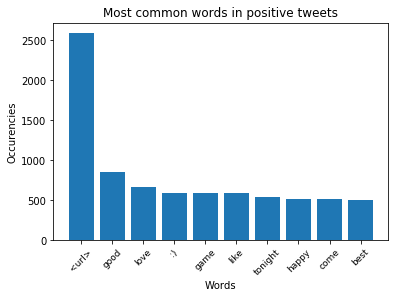

In [14]:
mostCommon_plot(count_pos, "positive", 10)

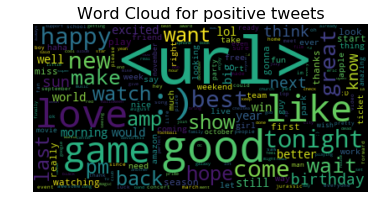

In [15]:
count_pos_dict = dict(count_pos)
draw_wordcloud(count_pos_dict, "Word Cloud for positive tweets")

#### Negative Tweets

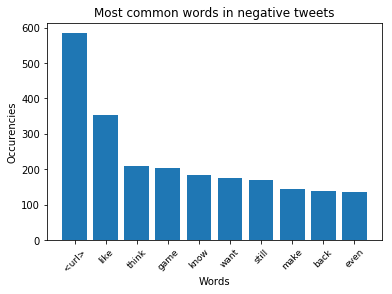

In [16]:
mostCommon_plot(count_neg, "negative", 10)

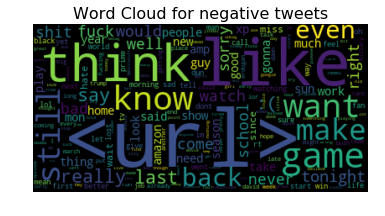

In [17]:
count_neg_dict = dict(count_neg)
draw_wordcloud(count_neg_dict, "Word Cloud for negative tweets")

#### Neutral Tweets

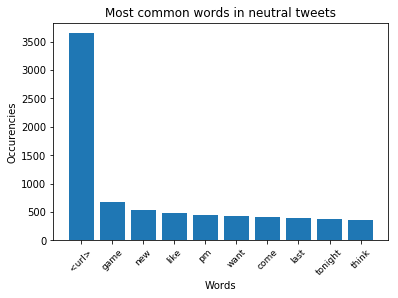

In [18]:
mostCommon_plot(count_neut, "neutral", 10)

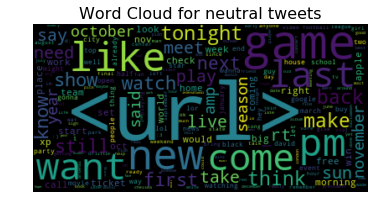

In [19]:
count_neut_dict = dict(count_neut)
draw_wordcloud(count_neut_dict, "Word Cloud for neutral tweets")

#### All Tweets

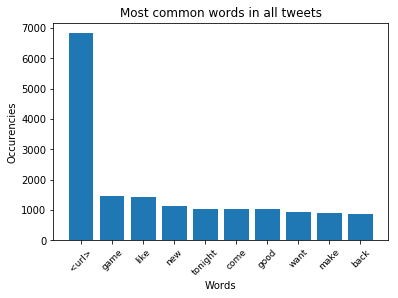

In [20]:
mostCommon_plot(counter, "all", 10)

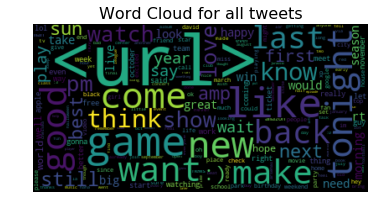

In [21]:
counter_dict = dict(counter)
draw_wordcloud(counter_dict, "Word Cloud for all tweets")

## Step 5: Vectorization

In this step, the tweets are turned into vectors of values using models trained with one of the aforementioned methods.

In [22]:
import pickle

In [23]:
# Preeliminary step for Bag of Words and TF-IDF approaches
# CountVectorizer and TFIDFVectorizer only accept strings as input

train_tweets = []
for item in train_data['tokens']:
    tweet = ' '.join(item)
    train_tweets.append(tweet)
    
test_tweets = []
for item in test_data['tokens']:
    tweet = ' '.join(item)
    test_tweets.append(tweet)

### Bag Of Words

The Bag Of Words method counts the occurencies of unique words in the whole body of tweets. Then, a frequency vector is created using the most common words. Each tweet is later going to be tranformed into this kind of vector.

The initialization of the vectorizer the uses the Bag Of Words approach is given those specific arguments to achieve more accurate results. The resulting vector is one that contains the 1500 most frequent words in all of the tweets.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features = 1500, min_df = 1, max_df = 1.0)

#### Create frequency vectors for all tweets and save the data in a .pkl file

In [25]:
## train_data ##

bow = bow_vectorizer.fit_transform(train_tweets)
bowArray = bow.toarray()

bowFile = open('bowResults.pkl', 'wb')
pickle.dump(bowArray, bowFile)
bowFile.close()

In [26]:
## test_data ##

bow_test = bow_vectorizer.transform(test_tweets)
bowtestArray = bow_test.toarray()

#### Or load the data from a pre-existing .pkl file

In [85]:
## just the train_data ##

bowFile = open('bowResults.pkl', 'rb')
bowArray = pickle.load(bowFile)
bowFile.close()

### TF-IDF

The TF-IDF method is similar to the Bag of Words method, however, instead of a frequency vector, it constructs a vector with word weights that are calculated by a specific formula. This formula prevents the words that appear too often in both one specific tweet and the whole body of tweets to get high weight values. These words most probably would not contribute to the correct interpretation of a tweet.

Similarly to the bag of word method, we have elected to take into account the 1500 most important words.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features = 1500, min_df = 1, max_df = 1.0)

#### Create weight vectors and save the data in a .pkl file

In [28]:
## train_data ##

tfidf = tfidf_vectorizer.fit_transform(train_tweets)

tfidfArray = tfidf.toarray()
tfidfFile = open('tfidfResults.pkl', 'wb')
pickle.dump(tfidfArray, tfidfFile)
tfidfFile.close()

In [29]:
## test_data ##

tfidf_test = tfidf_vectorizer.transform(test_tweets)
tfidf_testArray = tfidf_test.toarray()

#### Or load the data from a pre-existing .pkl file

In [ ]:
## just the train_data

tfidfFile = open('tfidfResults.pkl', 'rb')
tfidfArray = pickle.load(tfidfFile)
tfidfFile.close()

### Word Embeddings

The word embeddings method creates a multi-dimensional vector for every word, with each dimension representing the word's relationship to another word in the tweet body. The closer the vector points of a pair of words are the more related they are. 

The word embeddings model is initialized with the train dataset of tweets, with each word vector having 300 dimensions.

Because the Word2Vec model in the gensim library cannot vectorize the tweets, a class was implemented for this purpose. The class constructs a vector for each tweet by taking its words one by one, checking if the word is included in te Word2Vec model's vocabulary and, if it is, computing the mean of that word's vector and placing that value in the corresponding vector cell. If the word is not in the W2V vocabulary, 0 is placed in its cell.

In [125]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import random

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
        print(self.dim)

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

### Useful Functions ###

def tsne_plot(model, n):

    # Creates a TSNE model and plots it, slightly modified to visualize model for n words in its vocabulary
    labels = []
    tokens = []
    randomWords = [i for i in model.wv.vocab.keys()]
    randomWords = random.choices(randomWords, k = n)
    for word in randomWords:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
            textcoords='offset points',
                        ha='right',
                        va='bottom')
    plt.show()


In [116]:
# Word2Vec expects tokenized strings as input
tokenizedTrainTweets = train_data['tokens']
tokenizedTestTweets = test_data['tokens']

#### Train the model and save it in a .pkl file

In [131]:
model_w2v = Word2Vec(
            tokenizedTrainTweets,
            size=300, # desired no. of features/independent variables
            window=10, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 4, # no.of cores
            seed = 34)

model_w2v.train(tokenizedTrainTweets, total_examples= len(tokenizedTrainTweets), epochs=20)

weFile = open('weModel.pkl', 'wb')
pickle.dump(model_w2v, weFile)
weFile.close()

#### Or load the model from a pre-existing .pkl file

In [121]:
weFile = open('weModel.pkl', 'rb')
model_w2v = pickle.load(weFile)
weFile.close()

#### Visualize the model

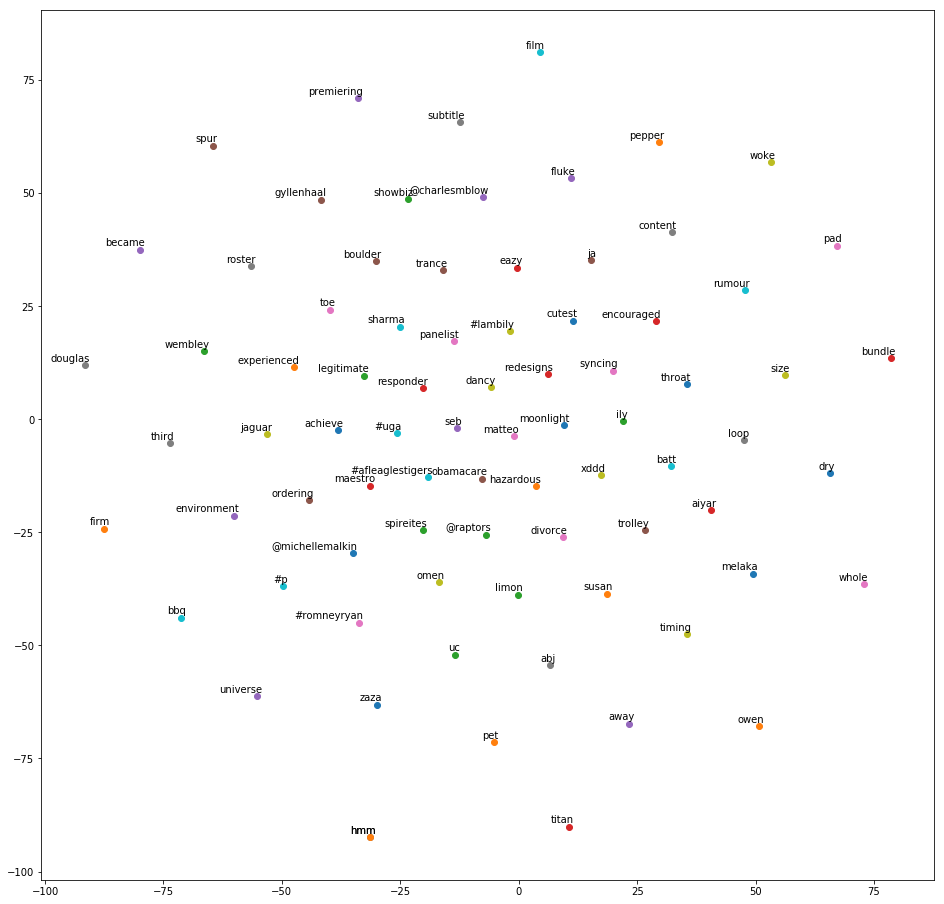

In [130]:
tsne_plot(model_w2v, 80)

#### Initialize the vectorizer that is to be used

In [84]:
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors))

weVectorizer = MeanEmbeddingVectorizer(w2v)

300


#### Create the vectors and save them in a .pkl file

In [88]:
## train_set ##

weArray = weVectorizer.transform(tokenizedTrainTweets)
weFile = open('weResults.pkl', 'wb')
pickle.dump(weArray, weFile)
weFile.close()

In [89]:
## test_set ##

weTestArray = weVectorizer.transform(tokenizedTestTweets)

#### Or load the vectors from a pre-existing .pkl file

In [86]:
## just the train_set ##

weFile = open('weResults.pkl', 'rb')
weArray = pickle.load(weFile)
weFile.close()

## Step 6: Expansion of the Word Embeddings features vector with the use of given lexica

In this step, the provided lexica were utilised in order to add more features to the vectors created by the word2vec models. These features are particularly effective at improving the accuracy of the Word Embeddings method.

In [90]:
### Some useful functions ###

def fileToDict(path):

    print("Opening path of valence_tweet dictionary")
    lexfile1 = open(path, 'r', encoding="utf8")
    contents = lexfile1.read().splitlines()

    Mydictionary = {}

    print("Creating dictionary...")
    for line in contents:
        splitLine = [word for word in line.split()]
        length = len(splitLine)
        if(length == 2):
            Mydictionary[splitLine[0]] = float(splitLine[1])
        else:
            mergedLine = ''
            for index in range(length - 1): #change it afterwards
                if index != (length - 2): 
                    mergedLine += splitLine[index] + ' '
                else:
                    mergedLine += splitLine[index]
            mytup = (mergedLine, splitLine[length - 1])
            Mydictionary[mergedLine] = float(splitLine[length - 1])

    print("Done!")
    return Mydictionary

def getDictToVec(token_list,MyDictionary):
    token_values = []
    for tweet in  token_list:
        value = []
        for index in range(len(tweet)):
            word = tweet[index]
            if word in MyDictionary.keys():
                value.append(MyDictionary[word])
        if not value:
            token_values.append(0)
        else:
            token_values.append(np.mean(value))

    token_values = np.array(token_values)
    token_values = np.vstack(token_values)

    return token_values

### Creating python dictionaries based on the lexica files for easier access

In [91]:
path = "../lexica/emotweet/valence_tweet.txt"
valence_tweet_dictionary = fileToDict(path)

Opening path of valence_tweet dictionary
Creating dictionary...
Done!


In [92]:
path = "../lexica/affin/affin.txt"
affin_dictionary = fileToDict(path)

Opening path of valence_tweet dictionary
Creating dictionary...
Done!


In [93]:
path = "../lexica/generic/generic.txt"
generic_dictionary = fileToDict(path)

Opening path of valence_tweet dictionary
Creating dictionary...
Done!


In [94]:
path = "../lexica/nrc/val.txt"
nrc_dictionary = fileToDict(path)

Opening path of valence_tweet dictionary
Creating dictionary...
Done!


In [95]:
path = "../lexica/nrctag/val.txt"
nrctag_dictionary = fileToDict(path)

Opening path of valence_tweet dictionary
Creating dictionary...
Done!


### Using the dictionaries to interpret the tweets

In [96]:
## train_set ##

valence_tweet_train_values = getDictToVec(train_data['tokens'], valence_tweet_dictionary)
affin_train_values = getDictToVec(train_data['tokens'], affin_dictionary)
generic_train_values = getDictToVec(train_data['tokens'], generic_dictionary)
nrc_train_values = getDictToVec(train_data['tokens'], nrc_dictionary)
nrctag_train_values = getDictToVec(train_data['tokens'], nrctag_dictionary)

In [97]:
## test_set ##

valence_tweet_test_values = getDictToVec(test_data['tokens'], valence_tweet_dictionary)
affin_test_values = getDictToVec(test_data['tokens'], affin_dictionary)
generic_test_values = getDictToVec(test_data['tokens'], generic_dictionary)
nrc_test_values = getDictToVec(test_data['tokens'], nrc_dictionary)
nrctag_test_values = getDictToVec(test_data['tokens'], nrctag_dictionary)

### Adding the extra features to the Word Embeddings features vector

In [98]:
## train_set ##

trainValues = np.hstack((valence_tweet_train_values, affin_train_values, generic_train_values, nrc_train_values, nrctag_train_values))
weLexArray = np.hstack((weArray, trainValues))

In [99]:
## test_set ##

testValues = np.hstack((valence_tweet_test_values, affin_test_values, generic_test_values, nrc_test_values, nrctag_test_values))
weLexTestArray = np.hstack((weTestArray, testValues))

## Step 7: Data Classification

In this step, the vectorized tweets are entered into the Support-Vector Machine and K-nearest neighbours classifiers in order to receive the final sentiment prediction. The classifiers are first trained using the train_data set and the prediction is made on the test_data set. The results vary from one method to the next and the results will be commented upon in the Conclusions section. 

##### Obtain the correct answers for the test_data set

In [100]:
file = open('../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt',"r")
lines = [line.rstrip('\n').split('\t') for line in file]
labelValue = [line[1] for line in lines]
file.close()

### Support-Vector Machine Classifier

Following are the initialization and training processes, as well as the predictions made by the SVM classifier, using the Bag Of Words method, the TF-IDF method, Word Embeddings and Word Embeddings with the added features from the lexica interpretations.

In [47]:
from sklearn import svm
from sklearn.metrics import f1_score
import time

#### Bag Of Words

#### Initialize classifier, train it and save it in a .pkl file

In [ ]:
svc_bow = svm.SVC(kernel='linear', C=1, probability=True)
svc_bow = svc_bow.fit(bowArray, train_data['emotion'])
svm_bow_classifier_file = open('svm_bow_classifier.pkl', 'wb')
pickle.dump(svc_bow, svm_bow_classifier_file)
svm_bow_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [48]:
svm_bow_classifier_file = open('svm_bow_classifier.pkl', 'rb')
svc_bow = pickle.load(svm_bow_classifier_file)
svm_bow_classifier_file.close()

#### Make a prediction and print score

In [49]:
bowPrediction = svc_bow.predict(bowtestArray)
bowResult = f1_score(labelValue, bowPrediction, average='micro')
print(bowResult)

0.5599967437316835


#### TF-IDF

#### Initialize classifier, train it and save it in a .pkl file

In [ ]:
svc_tfidf = svm.SVC(kernel='linear', C=1, probability=True)
svc_tfidf = svc_tfidf.fit(tfidfArray, train_data['emotion'])
svm_tfidf_classifier_file = open('svm_tfidf_classifier.pkl', 'wb')
pickle.dump(svc_tfidf, svm_tfidf_classifier_file)
svm_tfidf_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [50]:
svm_tfidf_classifier_file = "svm_tfidf_classifier.pkl"
svc_tfidf = pickle.load(open(svm_tfidf_classifier_file, 'rb'))

#### Make a prediction and print score

In [51]:
tfidfPrediction = svc_tfidf.predict(tfidf_testArray)
tfidfResult = f1_score(labelValue, tfidfPrediction, average='micro')
print(tfidfResult)

0.5586128296971671


#### Word Embeddings

#### Initialize classifier, train it and save it in a .pkl file

In [104]:
svc_we = svm.SVC(kernel='linear', C=1, probability=True)
svc_we = svc_we.fit(weArray, train_data['emotion'])
svm_we_classifier_file = open('svm_we_classifier.pkl', 'wb')
pickle.dump(svc_we, svm_we_classifier_file)
svm_we_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [102]:
svm_we_classifier_file = open('svm_we_classifier.pkl', 'rb')
svc_we = pickle.load(svm_we_classifier_file)
svm_we_classifier_file.close()

#### Make a prediction and print score

In [105]:
wePrediction = svc_we.predict(weTestArray)
weResult = f1_score(labelValue, wePrediction, average='micro')
print(weResult)

0.5359003581895149


#### Word Embeddings + extra features added in Step 6

#### Initialize classifier, train it and save it in a .pkl file

In [ ]:
svc_we_lex = svm.SVC(kernel='linear', C=1, probability=True)
svc_we_lex = svc_we_lex.fit(weLexArray, train_data['emotion'])
svm_we_lex_classifier_file = open('svm_we_lex_classifier.pkl', 'wb')
pickle.dump(svc_we_lex, svm_we_lex_classifier_file)
svm_we_lex_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [106]:
svm_we_lex_classifier_file = open('svm_we_lex_classifier.pkl', 'rb')
svc_we_lex = pickle.load(svm_we_lex_classifier_file)
svm_we_lex_classifier_file.close()

#### Make a prediction and print score

In [107]:
weLexPrediction = svc_we_lex.predict(weLexTestArray)
weLexResult = f1_score(labelValue, weLexPrediction, average='micro')
print(weLexResult)

0.5954900683816347


### ----------------------------------------------------------------------------------------------------------------------------------------------------------

### K-Nearest Neighbours Classifier

Following are the initialization and training processes, as well as the predictions made by the KNN classifying algorithm, using the Bag Of Words method, the TF-IDF method, Word Embeddings and Word Embeddings with the added features from the lexica interpretations.

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#### Bag Of Words

#### Initialize classifier and save it in a .pkl file

In [57]:
knn_bow = KNeighborsClassifier(n_neighbors=5)
knn_bow = knn_bow.fit(bowArray, train_data['emotion'])

knn_bow_classifier_file = open('knn_bow_classifier.pkl', 'wb')
pickle.dump(knn_bow, knn_bow_classifier_file)
knn_bow_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [69]:
knn_bow_classifier_file = open('knn_bow_classifier.pkl','rb')
knn_bow = pickle.load(knn_bow_classifier_file)
knn_bow_classifier_file.close()

#### Make a prediction and print score

In [70]:
knnBow_prediction = knn_bow.predict(bowtestArray)
knnBowResultF1 =f1_score(labelValue,knnBow_prediction,average='micro')
print(knnBowResultF1)

0.5065939433409313


#### TF-IDF

#### Initialize classifier and save it in a .pkl file

In [59]:
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
knn_tfidf = knn_tfidf.fit(tfidfArray, train_data['emotion'])

knn_tfidf_classifier_file = open('knn_tfidf_classifier.pkl', 'wb')
pickle.dump(knn_tfidf, knn_tfidf_classifier_file)
knn_tfidf_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [71]:
knn_tfidf_classifier_file = 'knn_tfidf_classifier.pkl'
knn_tfidf = pickle.load(open(knn_tfidf_classifier_file,'rb'))
#knn_tfidf_classifier_file.close()

#### Make a prediction and print score

In [72]:
knnTfidfprediction = knn_tfidf.predict(tfidf_testArray)
knnTfidfResultF1 = f1_score(labelValue,knnTfidfprediction,average='micro')
print(knnTfidfResultF1)

0.479648323021817


#### Word Embeddings

#### Initialize classifier and save it in a .pkl file

In [109]:
knn_we = KNeighborsClassifier(n_neighbors=5)
knn_we = knn_we.fit(weArray, train_data['emotion'])

knn_we_classifier_file = open('knn_we_classifier.pkl', 'wb')
pickle.dump(knn_we, knn_we_classifier_file)
knn_we_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [73]:
knn_we_classifier_file = open('knn_we_classifier.pkl','rb')
knn_we = pickle.load(knn_we_classifier_file)
knn_we_classifier_file.close()

#### Make a prediction and print score

In [110]:
knn_we_prediction = knn_we.predict(weTestArray)
knnWeResultF1 = f1_score(labelValue,knn_we_prediction,average='micro')
print(knnWeResultF1)

0.46532074242917615


#### Word Embeddings + extra features added in Step 6

#### Initialize classifier and save it in a .pkl file

In [ ]:
knn_we_lex = KNeighborsClassifier(n_neighbors=5)
knn_we_lex = knn_we_lex.fit(weLexArray, train_data['emotion'])
knn_we_lex_classifier_file = open('knn_we_lex_classifier.pkl', 'wb')
pickle.dump(knn_we_lex, knn_we_lex_classifier_file)
knn_we_lex_classifier_file.close()

#### Or load classifier from a pre-existing .pkl file

In [112]:
knn_we_lex_classifier_file = open('knn_we_lex_classifier.pkl','rb')
knn_we_lex = pickle.load(knn_we_lex_classifier_file)
knn_we_lex_classifier_file.close()

#### Make a prediction and print score

In [113]:
knn_we_lex_prediction = knn_we_lex.predict(weLexTestArray)
knnWeLexResultF1 = f1_score(labelValue,knn_we_lex_prediction,average='micro')
print(knnWeLexResultF1)

0.5478671442526865


## Conclusion

The scores returned for each classifier-method combination are presented in the table below.

### Scores in SVM and KNN

In [114]:
data = np.array([['','BOW','TFIDF','WE', 'WE+LEX'],['SVM','{:.2}'.format(bowResult),'{:.2}'.format(tfidfResult),'{:.2}'.format(weResult), '{:.2}'.format(weLexResult)],['KNN','{:.2}'.format(knnBowResultF1),'{:.2}'.format(knnTfidfResultF1),'{:.2}'.format(knnWeResultF1), '{:.2}'.format(knnWeLexResultF1)]])

dataframe = pd.DataFrame(data=data[1:,1:],
                  index=data[1:,0],
                  columns=data[0,1:])
dataframe

,BOW,TFIDF,WE,WE+LEX
SVM,0.56,0.56,0.54,0.6
KNN,0.51,0.48,0.47,0.55


The conclusion we can draw from the above are the following:

    -> SVM vs KNN: The SVM classifier has been shown to score consistently higher than its KNN counterpart. However, the KNN algorithm is considerably faster in getting results.
    
    -> In the KNN classifier the number of neighbors was not randomly chosen. It had to be an odd value in order to avoid confusion between two classes of data. Also, a higher than 1 value for the number of neighbors reduces the effect that noise in the dataset has on the accuracy of the results. Last but not least, multiples of the number of classes in the problem were avoided and k=5 gave consistently better results that other values chosen.
    
    -> The BOW and TF-IDF methods return relatively similar scores, with the BOW method prevailing when used with the KNN method. As we can see from the graphs of the most common words above, there are words that appear frequently in the text and are useful to assess the sentiment of a tweet, such as "love",":)" and "like" being some of the most common words in the 'positive' tweets. These kind of words don't get a high weight in the tf-idf model, due to their increased frequency of appearance in many tweets, which explains the lower accuracy score.
    
    -> The use of lexica when the maximum number of features for Word Embeddings is 300 appears to greatly affect the score, both with the SVM classifier and the KNN algorithm. When other tests were run with a greater number of features, the use of lexica did not have as strong an influence.